In [2]:
import kaggle

In [10]:
kaggle.api.authenticate()

In [17]:
kaggle.api.dataset_list('votes')

[mlg-ulb/creditcardfraud,
 hugomathien/soccer,
 ronitf/heart-disease-uci,
 lava18/google-play-store-apps,
 tmdb/tmdb-movie-metadata,
 zynicide/wine-reviews,
 START-UMD/gtd,
 mczielinski/bitcoin-historical-data,
 mehdidag/black-friday,
 karangadiya/fifa19,
 datasnaek/youtube-new,
 abcsds/pokemon,
 russellyates88/suicide-rates-overview-1985-to-2016,
 borismarjanovic/price-volume-data-for-all-us-stocks-etfs,
 unsdsn/world-happiness,
 uciml/iris,
 rounakbanik/the-movies-dataset,
 worldbank/world-development-indicators,
 wendykan/lending-club-loan-data,
 mohansacharya/graduate-admissions]

In [32]:
import pandas as pd
import numpy as np

In [33]:
df = pd.read_csv('data/^GSPC.csv')

In [34]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-01,16.660000,17.090000,16.650000,17.049999,17.049999,42570000
1,1950-02-01,17.049999,17.350000,16.990000,17.219999,17.219999,33430000
2,1950-03-01,17.240000,17.610001,17.070000,17.290001,17.290001,40410000
3,1950-04-01,17.340000,18.070000,17.340000,18.070000,18.070000,48250000
4,1950-05-01,18.219999,18.780001,18.110001,18.780001,18.780001,45080000


In [35]:
df['Adj Close Diff'] = df['Adj Close']/df['Adj Close'].shift()

In [36]:
df['Log Adj Close Diff'] = np.log(df['Adj Close Diff'])

In [37]:
np.exp(df['Log Adj Close Diff'].mean())**12

1.0766989707555843

In [38]:
1.03**(1/12)

1.0024662697723037

# What happens if every period I either:
* put the excess revenue (over average revenue) and put in safe investment (3%) or 
* put funds from the safe investment to reach average revenuem

In [39]:
class State():
    def __init__(self, price):
        self.invest = price
        self.invest_history = [self.invest]
        self.safe = 0
        self.safe_history = [self.safe]

    def sell(self, revenue, expected_revenue):
        # put excess revenue in safe
        excess_revenue = expected_revenue - revenue
        self.invest -= excess_revenue
        self.safe += excess_revenue

    def buy(self, revenue, expected_revenue):
        # put funds in investment
        funds = expected_revenue - revenue
        self.invest += funds
        self.safe -= funds
        


def smoothify(prices):
    diffs = prices/prices.shift()
    av = np.exp(np.mean(np.log(diffs)))
    print(av)
    state = State(prices[0])
    for diff,price in zip(diffs[1:],prices[1:]):
#         print('----------')
#         print(price)
        expected_revenue = state.invest*av - state.invest
#         print(expected_revenue)
        revenue = state.invest*diff - state.invest
#         print(revenue)
        state.invest *= av
#         print(state.invest)
        state.invest_history.append(state.invest)
        state.safe *= 1.0024
#         print(state.safe)
        state.safe_history.append(state.safe)
        excess_revenue = expected_revenue - revenue
        state.safe += excess_revenue

    return state
            
state = smoothify(df['Adj Close'])
        
            

1.0061773224372066


In [40]:
s = pd.Series(state.invest_history)

In [41]:
(s/s.shift()).mean()

1.0061773224372066

In [42]:
s_safe = pd.Series(state.safe_history)

In [43]:
import matplotlib.pyplot as plt

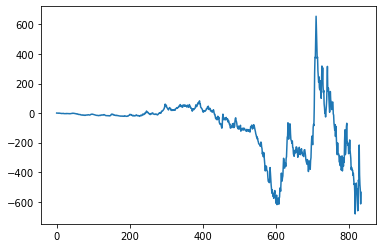

In [44]:
plt.plot(state.safe_history)

In [45]:
0.08/12

0.006666666666666667

In [46]:
df = df.dropna()

In [47]:
def min_take(sample_size=12*40, x=1000000, t=0.07):
    sample = df.sample(sample_size)
    takes = []
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = x*t/12
        x-=take
        takes.append(take)
    return min(takes)

In [48]:
min_takes = [min_take() for _ in range(1000)]

In [49]:
sum(min_takes)/len(min_takes)

3582.6058429752134

(array([ 15.,  57., 110., 157., 176., 146., 121., 113.,  78.,  27.]),
 array([ 676.15117296, 1251.11093476, 1826.07069657, 2401.03045837,
        2975.99022017, 3550.94998197, 4125.90974378, 4700.86950558,
        5275.82926738, 5850.78902919, 6425.74879099]),
 <BarContainer object of 10 artists>)

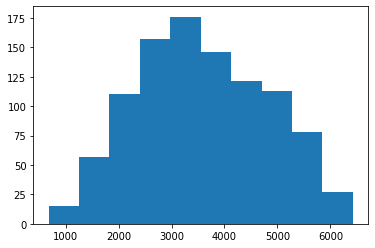

In [50]:
plt.hist(min_takes)

In [51]:
def is_bankrupt(t=0.05, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    take = x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        x-=take
        if x<0:
            return True
    return False

In [52]:
bankrupcies = [is_bankrupt() for _ in range(100)]

In [53]:
sum(bankrupcies)/len(bankrupcies)

0.11

In [70]:
def get_bankrupcy_prob(t, s=12*40, N=100):
    bankrupcies = [is_bankrupt(t, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [55]:
bankrupcy_probs = [get_bankrupcy_prob(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [56]:
bankrupcy_probs

[0.0, 0.0, 0.0, 0.03, 0.08, 0.16, 0.37, 0.7, 0.78, 0.83]

In [57]:
def is_bankrupt2(t=0.07, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = x*t/12
        x-=take
        if take<min_take:
            return True
    return False

In [69]:
def get_bankrupcy_prob2(t, m=.5, s=12*40, N=100):
    bankrupcies = [is_bankrupt2(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [59]:
bankrupcy_probs = [get_bankrupcy_prob2(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [60]:
bankrupcy_probs

[0.01, 0.03, 0.02, 0.05, 0.08, 0.19, 0.42, 0.51, 0.73, 0.84]

In [67]:
def is_bankrupt3(t=0.06, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = max(x*t/12, min_take)
        x-=take
        if x<0:
            return True
    return False

In [68]:
def get_bankrupcy_prob3(t, m=.5, s=12*40, N=100):
    bankrupcies = [is_bankrupt3(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [80]:
bankrupcy_probs = [get_bankrupcy_prob3(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [81]:
bankrupcy_probs

[0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.12, 0.32, 0.48]

In [82]:
def is_bankrupt4(t=0.06, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    max_take = x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = min(max(x*t/12, min_take),max_take)
        x-=take
        if x<0:
            return True
    return False

In [86]:
def get_bankrupcy_prob4(t, m=.6, s=12*40, N=100):
    bankrupcies = [is_bankrupt4(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [87]:
bankrupcy_probs = [get_bankrupcy_prob4(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [88]:
bankrupcy_probs

[0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.1, 0.19, 0.36, 0.51]